In [30]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
import findspark

findspark.init('spark-3.5.1-bin-hadoop3')

In [33]:
from pyspark.sql import SparkSession

In [34]:
spark = SparkSession.builder \
    .appName("Cassandra Connection") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.1") \
    .config("spark.cassandra.connection.host", "cassandra1") \
    .config("spark.cassandra.connection.port", "9042") \
    .getOrCreate()

In [35]:
print("Spark versão:", spark.version)


Spark versão: 3.5.1


In [36]:
df = spark.read.format("org.apache.spark.sql.cassandra").options(table="genero_por_idade",keyspace="analises").load()

In [37]:
df.show(10)

+-----+--------------------+-----------+
|idade|              userid|     genero|
+-----+--------------------+-----------+
|   44|22908be5-3734-4c4...|      Drama|
|   61|491f8a6e-3eee-444...|     Action|
|   66|9ae69094-3dbb-487...|Documentary|
|   46|48994704-f1ec-4a5...|   Thriller|
|   30|dc6a9e71-f874-406...|   Thriller|
|   70|46aff442-5ad9-47d...|     Comedy|
|   62|ec29da07-7f51-428...|     Sci-Fi|
|   48|b7d5e183-0d4d-418...|     Sci-Fi|
|   60|20ff0192-9cb4-4e5...|Documentary|
|   57|00939433-d6a5-469...|   Thriller|
+-----+--------------------+-----------+
only showing top 10 rows



In [38]:
df_menores_20 = df.filter(df.idade < 20)
df_entre_20_30 = df.filter((df.idade >= 20) & ((df.idade < 30)))
df_entre_30_40 = df.filter((df.idade >= 30) & ((df.idade < 40)))
df_entre_40_50 = df.filter((df.idade >= 40) & ((df.idade < 50)))
df_maiores_50 = df.filter(df.idade > 50)

In [39]:
g5 = df_maiores_50.groupBy('genero').count()
g1 = df_menores_20.groupBy('genero').count()
g2 = df_entre_20_30.groupBy('genero').count()
g3 = df_entre_30_40.groupBy('genero').count()
g4 = df_entre_40_50.groupBy('genero').count()
grupos = [g1,g2,g3,g4,g5] 

In [40]:
g5.show()

+-----------+-----+
|     genero|count|
+-----------+-----+
|   Thriller|  321|
|      Drama|  325|
|Documentary|  332|
|     Comedy|  357|
|     Action|  333|
|     Sci-Fi|  336|
+-----------+-----+



In [41]:
titles = ['Menores de 20', '20 ate 30', '30 ate 40', '40 ate 50', 'maiores 50']


In [42]:
import matplotlib.pyplot as plt


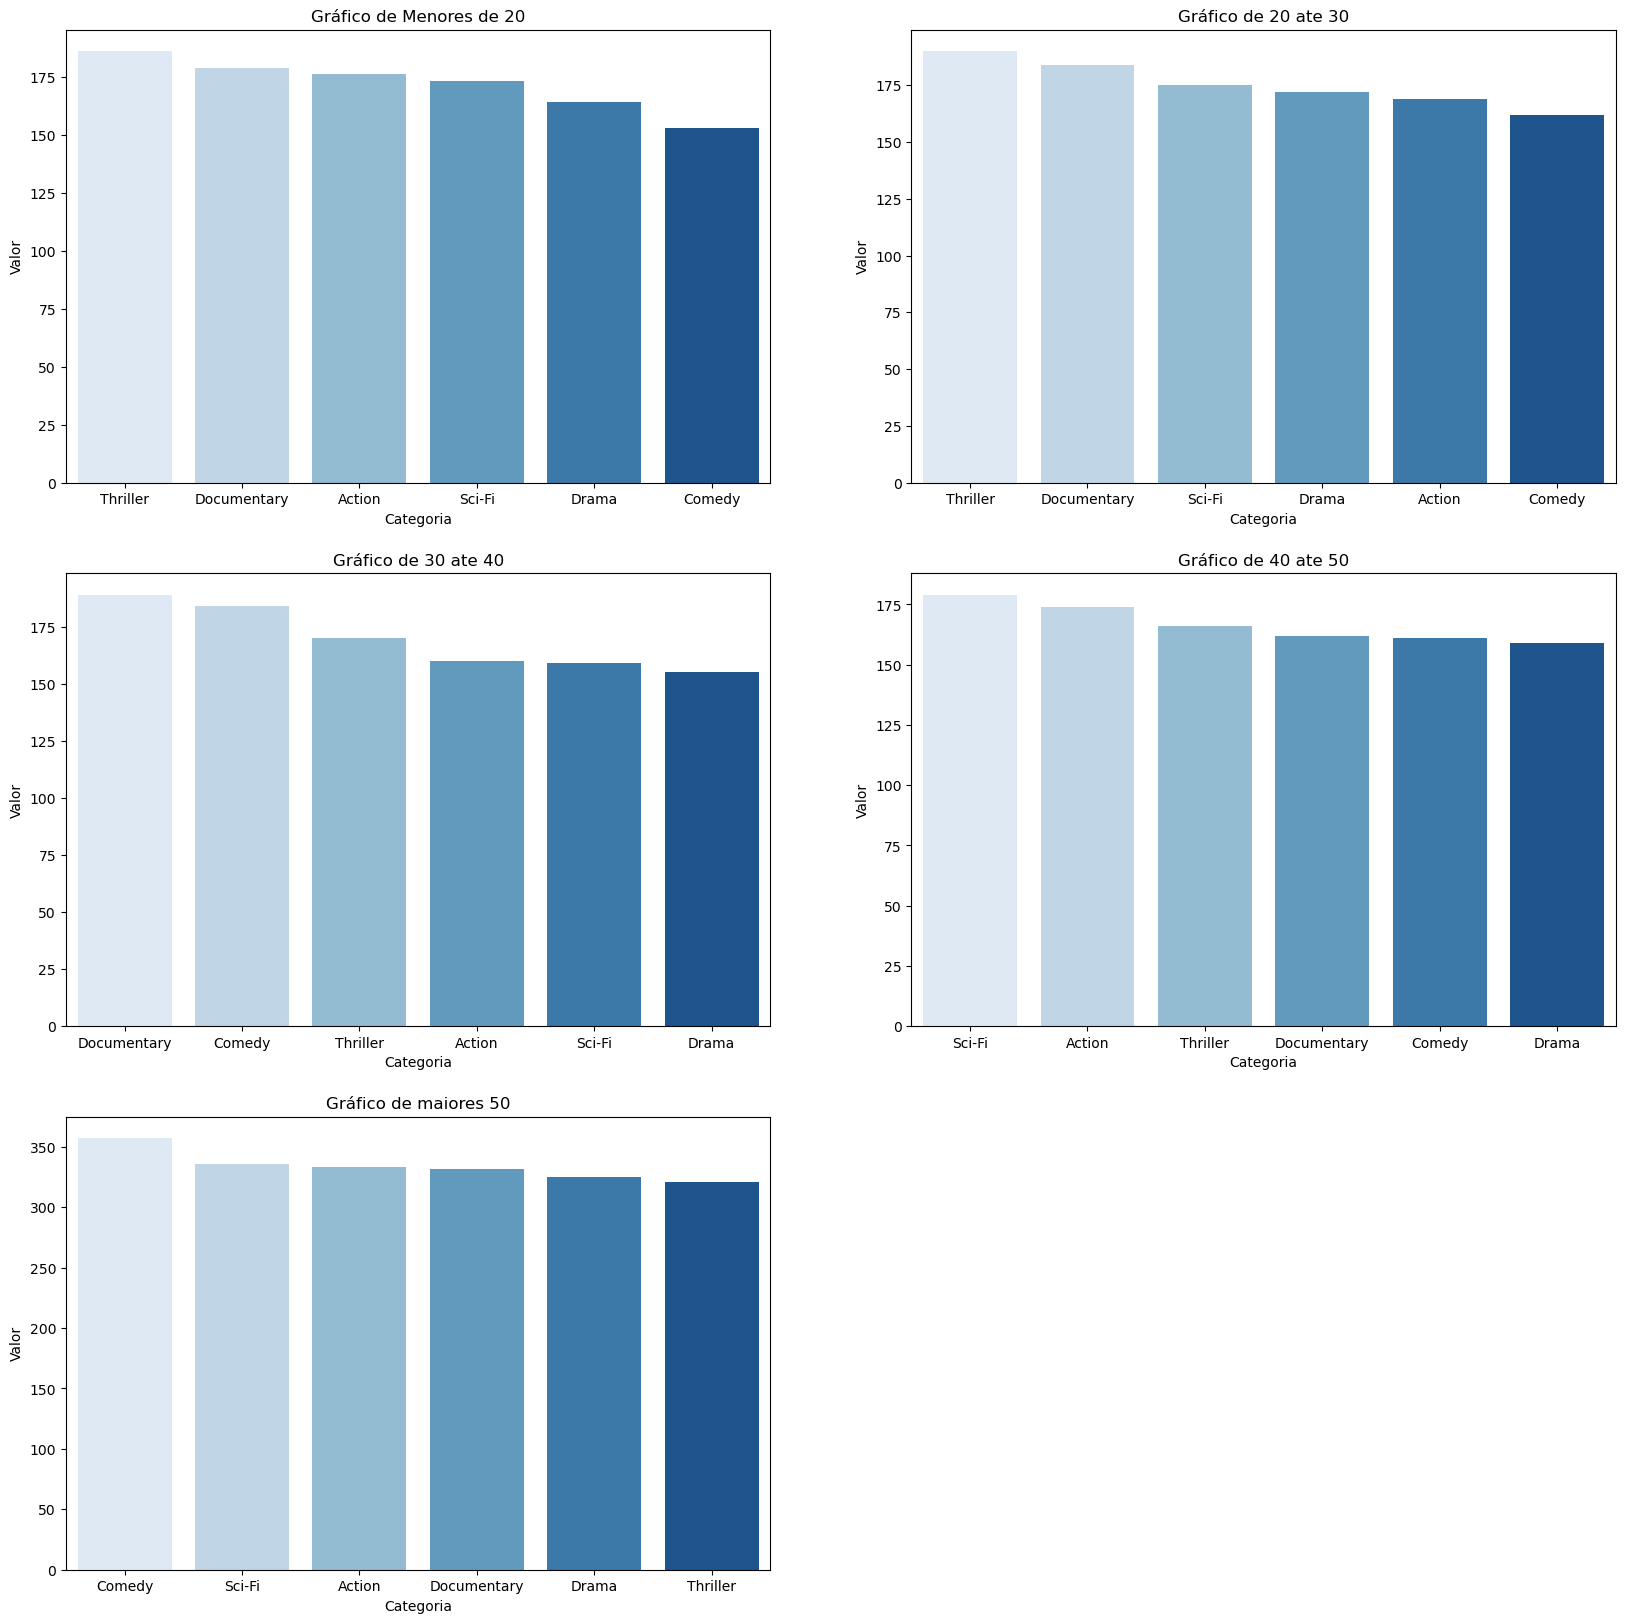

In [43]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(3, 2, figsize=(20,20))  # 1 linha, 2 colunas
for i, value in enumerate(titles):
    ax = axs[i // 2, i % 2]  # Determinar a posição do subplot
    sns.barplot(x='genero', y='count', data=grupos[i].toPandas().sort_values(by='count', ascending=False), ax=ax, palette='Blues')
    ax.set_title(f'Gráfico de {value}')
    ax.set_xlabel('Categoria')
    ax.set_ylabel('Valor')

if len(titles) < len(axs.flatten()):
    fig.delaxes(axs.flatten()[len(titles)])    

## POR IDH e GENERO

In [44]:
df_idf = spark.read.format("org.apache.spark.sql.cassandra").options(table="idh_por_pais",keyspace="analises").load()

In [45]:
df_genero = spark.read.format("org.apache.spark.sql.cassandra").options(table="genero_por_pais",keyspace="analises").load()

In [46]:
df_genero.show()

+-------+--------------------+-----------+
|   pais|              userid|     genero|
+-------+--------------------+-----------+
|uruguay|2010e4f0-c18b-42f...|Documentary|
|uruguay|2524e811-fa46-4c3...|     Sci-Fi|
|uruguay|2cf18008-5721-488...|      Drama|
|uruguay|4442d07a-ac32-40b...|      Drama|
|uruguay|45a89081-9831-481...|   Thriller|
|uruguay|47e33572-f817-421...|      Drama|
|uruguay|48ef979e-1366-47c...|     Action|
|uruguay|5b1a092b-d65a-448...|      Drama|
|uruguay|61df34b4-72c3-428...|     Action|
|uruguay|6cd05311-32e0-467...|     Comedy|
|uruguay|7cd867e0-5311-46c...|     Action|
|uruguay|7dba1e41-be7c-419...|     Sci-Fi|
|uruguay|81376fc3-12f3-442...|      Drama|
|uruguay|a659f26a-8397-495...|      Drama|
|uruguay|ba65824b-dfcc-463...|      Drama|
|uruguay|bf97bf1a-6553-40d...|     Sci-Fi|
|uruguay|c0cad314-c93b-47a...|     Comedy|
|uruguay|c8d20505-5d4e-47c...|     Comedy|
|uruguay|cd674bb2-9be5-4d2...|     Action|
|uruguay|e275ec6b-4a1a-4c4...|   Thriller|
+-------+--

In [47]:
df_genero = df_genero.groupby(['pais', 'genero']).count()

In [48]:
df_joined  = df_genero.join(df_idf, on="pais", how="inner")

In [49]:
df_joined.show()

+------------+-----------+-----+-----+
|        pais|     genero|count|  idh|
+------------+-----------+-----+-----+
|        fiji|     Comedy|    7|0.742|
|        fiji|     Sci-Fi|    3|0.742|
|        fiji|   Thriller|    9|0.742|
|        fiji|      Drama|    2|0.742|
|        fiji|Documentary|    5|0.742|
|        fiji|     Action|    5|0.742|
|turkmenistan|     Sci-Fi|    2| 0.71|
|turkmenistan|Documentary|    8| 0.71|
|turkmenistan|     Action|    4| 0.71|
|turkmenistan|     Comedy|   10| 0.71|
|turkmenistan|   Thriller|    5| 0.71|
|       nauru|      Drama|    2| 0.74|
|       nauru|Documentary|    4| 0.74|
|       nauru|     Action|    4| 0.74|
|       nauru|     Sci-Fi|    2| 0.74|
|       nauru|     Comedy|   11| 0.74|
|       nauru|   Thriller|    1| 0.74|
|      uganda|     Action|    7|0.512|
|      uganda|     Sci-Fi|    5|0.512|
|      uganda|Documentary|   12|0.512|
+------------+-----------+-----+-----+
only showing top 20 rows



In [50]:
columns = ['Documentary','Sci-Fi', 'Comedy', 'Action', 'Drama', 'Thriller' , 'idh' ]
colunas  = pd.DataFrame(columns=columns)

In [51]:
distinct_names = df_genero.select("pais").distinct()
distinct_names = distinct_names.toPandas()

In [52]:
distinct_names = pd.concat([distinct_names, colunas], ignore_index=True)


In [53]:
distinct_names.head(10)

,pais,Documentary,Sci-Fi,Comedy,Action,Drama,Thriller,idh
0,austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,montserrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tunisia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,saint helena,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,haiti,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,papua new guinea,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,cuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,timor-leste,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,guinea,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,croatia,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
rows = df_joined.collect()
len(rows)

1049

In [55]:
for row in rows:
    distinct_names.loc[distinct_names.pais == row['pais'],row['genero']]= row['count']
    distinct_names.loc[distinct_names.pais == row['pais'],'idh']= row['idh']

In [56]:
distinct_names_cleaned = distinct_names.dropna()


In [57]:
print(type(distinct_names_cleaned))

<class 'pandas.core.frame.DataFrame'>


In [58]:
distinct_names_cleaned.head(10)

,pais,Documentary,Sci-Fi,Comedy,Action,Drama,Thriller,idh
0,austria,4,4,5,4,5,5,0.901
2,tunisia,2,3,1,3,5,6,0.75
4,haiti,2,4,3,1,2,6,0.503
5,papua new guinea,3,6,4,4,5,5,0.577
6,cuba,5,2,3,8,4,1,0.783
7,timor-leste,6,6,4,4,5,2,0.615
9,croatia,7,4,1,5,7,5,0.851
10,azerbaijan,3,4,5,7,3,3,0.755
11,solomon islands,10,2,5,8,13,3,0.691
12,venezuela,4,3,4,4,4,6,0.765


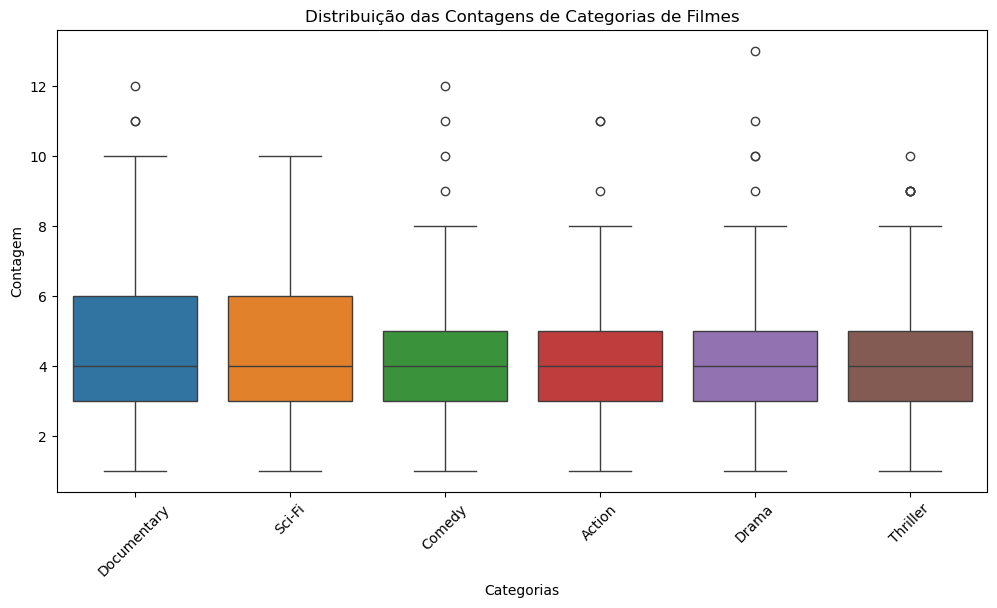

In [59]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=distinct_names_cleaned[['Documentary', 'Sci-Fi', 'Comedy', 'Action', 'Drama', 'Thriller']])
plt.title('Distribuição das Contagens de Categorias de Filmes')
plt.ylabel('Contagem')
plt.xlabel('Categorias')
plt.xticks(rotation=45)
plt.show()

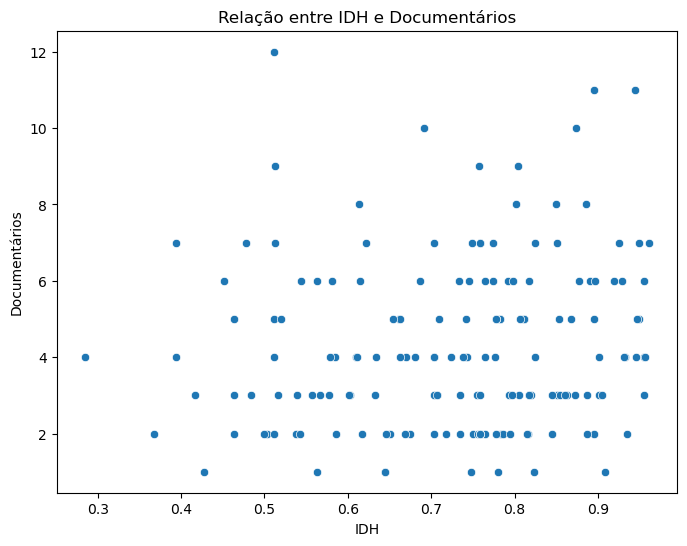

In [170]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='idh', y='Documentary', data=distinct_names_cleaned)
plt.title('Relação entre IDH e Documentários')
plt.xlabel('IDH')
plt.ylabel('Documentários')
plt.show()

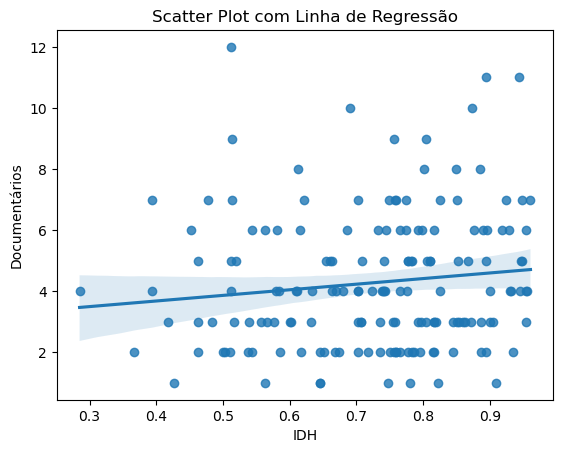

In [190]:
df = pd.DataFrame()

df['Y']  =  pd.to_numeric(distinct_names_cleaned['Documentary'], errors='coerce')
df['X'] =  pd.to_numeric(distinct_names_cleaned['idh'], errors='coerce')
# Criar o regplot
sns.regplot(x='X', y='Y', data=df)

# Adicionar título e rótulos
plt.title('Scatter Plot com Linha de Regressão')
plt.xlabel('IDH')
plt.ylabel('Documentários')

# Mostrar o gráfico
plt.show()


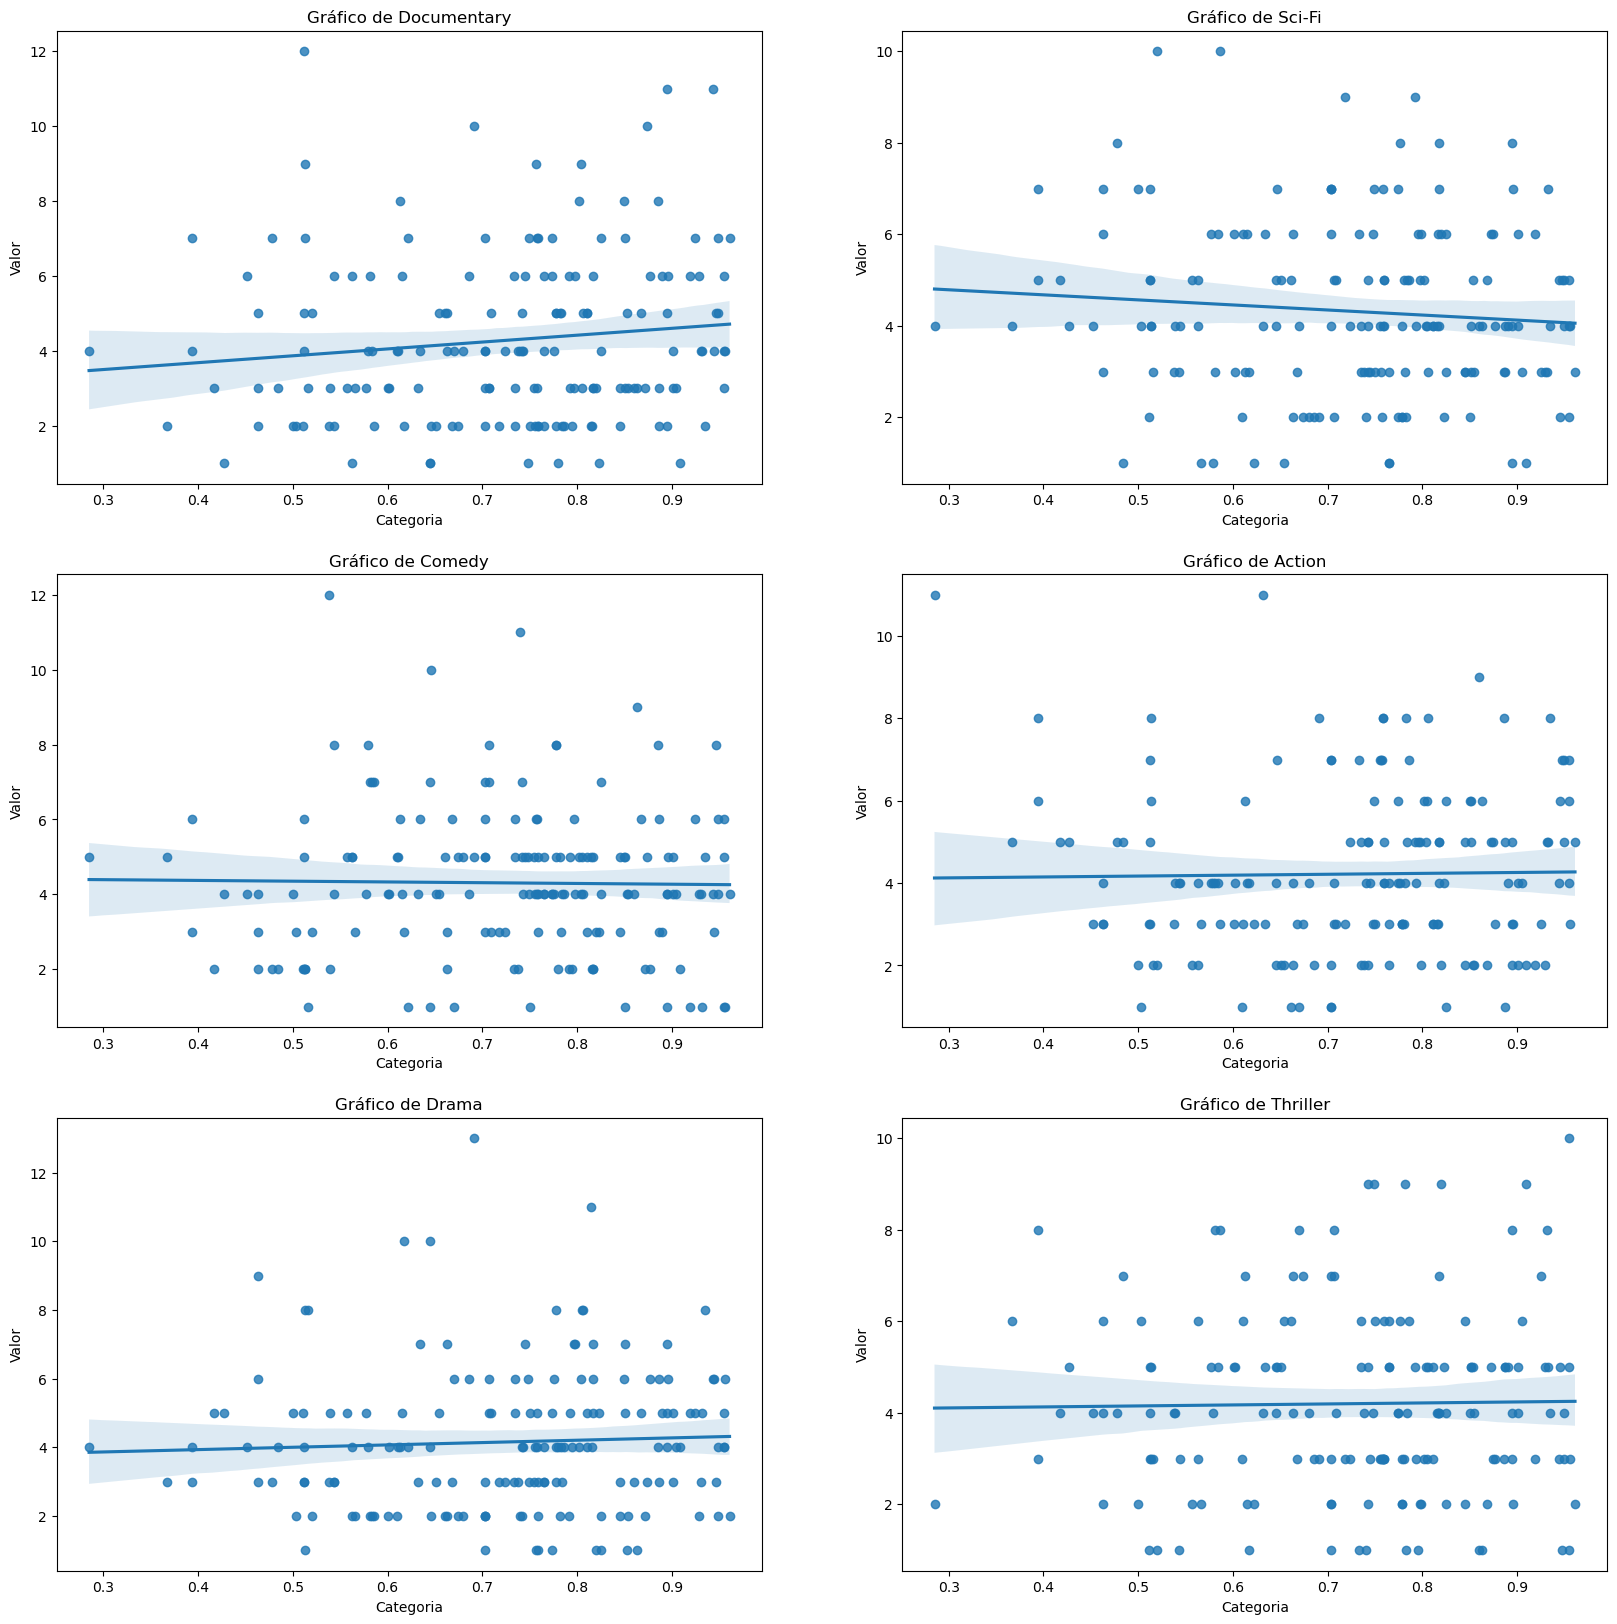

In [206]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))  # 1 linha, 2 colunas

for i, value in enumerate(['Documentary','Sci-Fi', 'Comedy', 'Action', 'Drama', 'Thriller']):
    df = pd.DataFrame()
    ax = axs[i // 2, i % 2]  # Determinar a posição do subplot
    df['Y']  =  pd.to_numeric(distinct_names_cleaned[value], errors='coerce')
    df['X'] =  pd.to_numeric(distinct_names_cleaned['idh'], errors='coerce')
    sns.regplot(x='X', y='Y', data=df,ax=ax)
    ax.set_title(f'Gráfico de {value}')
    ax.set_xlabel('Categoria')
    ax.set_ylabel('Valor')

#if len(titles) < len(axs.flatten()):
 #   fig.delaxes(axs.flatten()[len(titles)])    

In [61]:
def classificar_pais(idh):
    if idh > 0.8:
        return '0'
    elif idh < 0.5:
        return '1'
    else:
        return '2'

In [62]:
desenvolvido = distinct_names_cleaned[distinct_names_cleaned['idh'] > 0.8]
sub = distinct_names_cleaned[distinct_names_cleaned['idh'] < 0.5]
em_desenv = distinct_names_cleaned[(distinct_names_cleaned['idh'] <= 0.8) & (distinct_names_cleaned['idh'] >= 0.5) ]
paises_clas = [desenvolvido,sub,em_desenv]

In [63]:
pais_name = 'france'
pais_index = distinct_names_cleaned.loc[distinct_names_cleaned.pais == pais_name].index
pais_idh = (distinct_names_cleaned.loc[distinct_names_cleaned.pais == pais_name, distinct_names_cleaned.columns[7:8]]).values[0]
pais_idh[0]

0.9010000228881836

In [64]:
(distinct_names_cleaned.loc[distinct_names_cleaned.pais == pais_name, distinct_names_cleaned.columns[1:7]]).values.flatten()

array([3, 6, 4, 2, 3, 4], dtype=object)

In [65]:
#mean_stats = paises_clas[0].iloc[:, 1:7].mean().values  # Média para todas as categorias

In [66]:

labels = distinct_names_cleaned.columns[1:7]  # Excluindo 'Country' e 'IDH'
#pais_stats = distinct_names_cleaned.iloc[pais_index[0], 1:7].values  # Valores para Guatemala
pais_stats =  (distinct_names_cleaned.loc[distinct_names_cleaned.pais == pais_name, distinct_names_cleaned.columns[1:7]]).values.flatten()
#mean_stats = distinct_names_cleaned.iloc[:, 1:7].mean().values  # Média para todas as categorias
mean_stats = paises_clas[0].iloc[:, 1:7].mean().values
todos = distinct_names_cleaned.iloc[:, 1:7].mean().values  # Média para todas as categorias

In [279]:
labels

Index(['Documentary', 'Sci-Fi', 'Comedy', 'Action', 'Drama', 'Thriller'], dtype='object')

In [67]:
import numpy as np

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
pais_stats = np.concatenate((pais_stats,[pais_stats[0]]))
mean_stats = np.concatenate((mean_stats,[mean_stats[0]]))
todos = np.concatenate((todos,[todos[0]]))

angles += angles[:1]

In [280]:
angles

[0.0,
 1.0471975511965976,
 2.0943951023931953,
 3.141592653589793,
 4.1887902047863905,
 5.235987755982988,
 0.0]

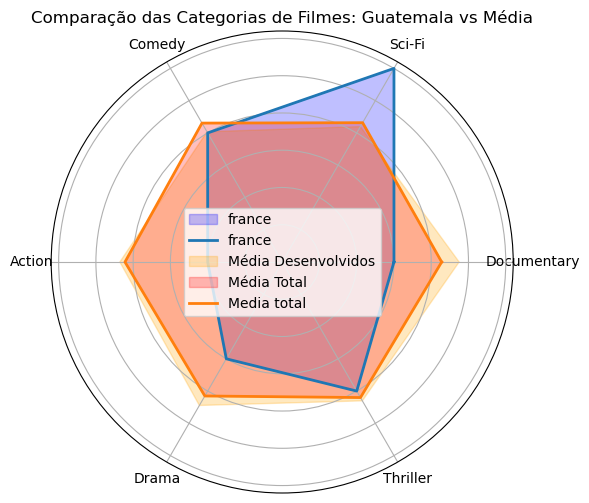

In [68]:

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))

ax.fill(angles, pais_stats, color='blue', alpha=0.25, label=pais_name)

ax.plot(angles, pais_stats, linewidth=2, label=pais_name)

ax.fill(angles, mean_stats, color='orange', alpha=0.25, label='Média Desenvolvidos')
ax.fill(angles, todos, color='red', alpha=0.25, label='Média Total')
ax.plot(angles, todos, linewidth=2, label="Media total ")


ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Comparação das Categorias de Filmes: Guatemala vs Média')
plt.legend()
plt.show()

In [ ]:
desenvolvido.
sub
em_desenv

In [154]:
mais_desenvolvido = desenvolvido.sort_values(by='idh',ascending=False).head(1)
mais_desenvolvido

,pais,Documentary,Sci-Fi,Comedy,Action,Drama,Thriller,idh
24,norway,7,3,4,5,2,2,0.961


In [155]:
pior_idh = sub.sort_values(by='idh',ascending=True).head(1)
pior_idh

,pais,Documentary,Sci-Fi,Comedy,Action,Drama,Thriller,idh
221,somalia,4,4,5,11,4,2,0.285


In [156]:
media_idh = em_desenv['idh'].mean()
pais_media = em_desenv.iloc[(em_desenv['idh'] - media_idh).abs().argsort()[:1]]

In [159]:
pais_media

,pais,Documentary,Sci-Fi,Comedy,Action,Drama,Thriller,idh
13,el salvador,2,2,5,3,2,7,0.674


In [160]:
pais_media = pais_media.iloc[:, 1:7].values.flatten()
maior_idh = mais_desenvolvido.iloc[:, 1:7].values.flatten()
pior_idh = pior_idh.iloc[:, 1:7].values.flatten()


In [161]:
pior_idh

array([4, 4, 5, 11, 4, 2], dtype=object)

In [162]:
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
pais_media = np.concatenate((pais_media,[pais_media[0]]))
maior_idh = np.concatenate((maior_idh,[maior_idh[0]]))
pior_idh = np.concatenate((pior_idh,[pior_idh[0]]))

angles += angles[:1]

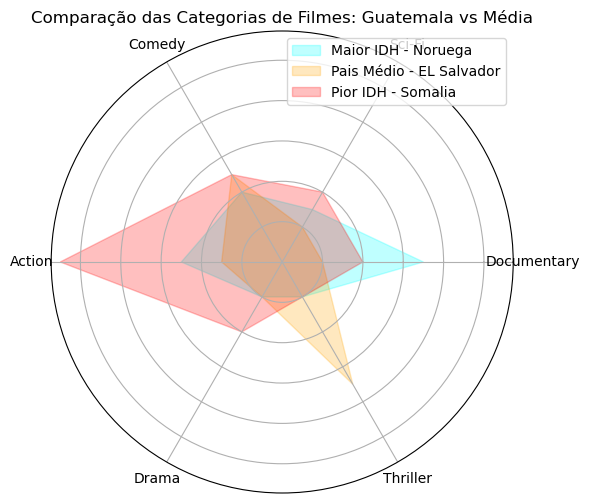

In [207]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))

#ax.fill(angles, pais_stats, color='blue', alpha=0.25, label=pais_name)
#ax.plot(angles, pais_stats, linewidth=2, label=pais_name)

ax.fill(angles, maior_idh, color='cyan', alpha=0.25, label='Maior IDH - Noruega')
ax.fill(angles, pais_media, color='orange', alpha=0.25, label='Pais Médio - EL Salvador')
ax.fill(angles, pior_idh, color='red', alpha=0.25, label='Pior IDH - Somalia')

#ax.plot(angles, pior_idh, linewidth=2, label="Pior IDH ")


ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Comparação das Categorias de Filmes: Guatemala vs Média')
plt.legend()
plt.show()

In [208]:
pip install geopandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 3.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


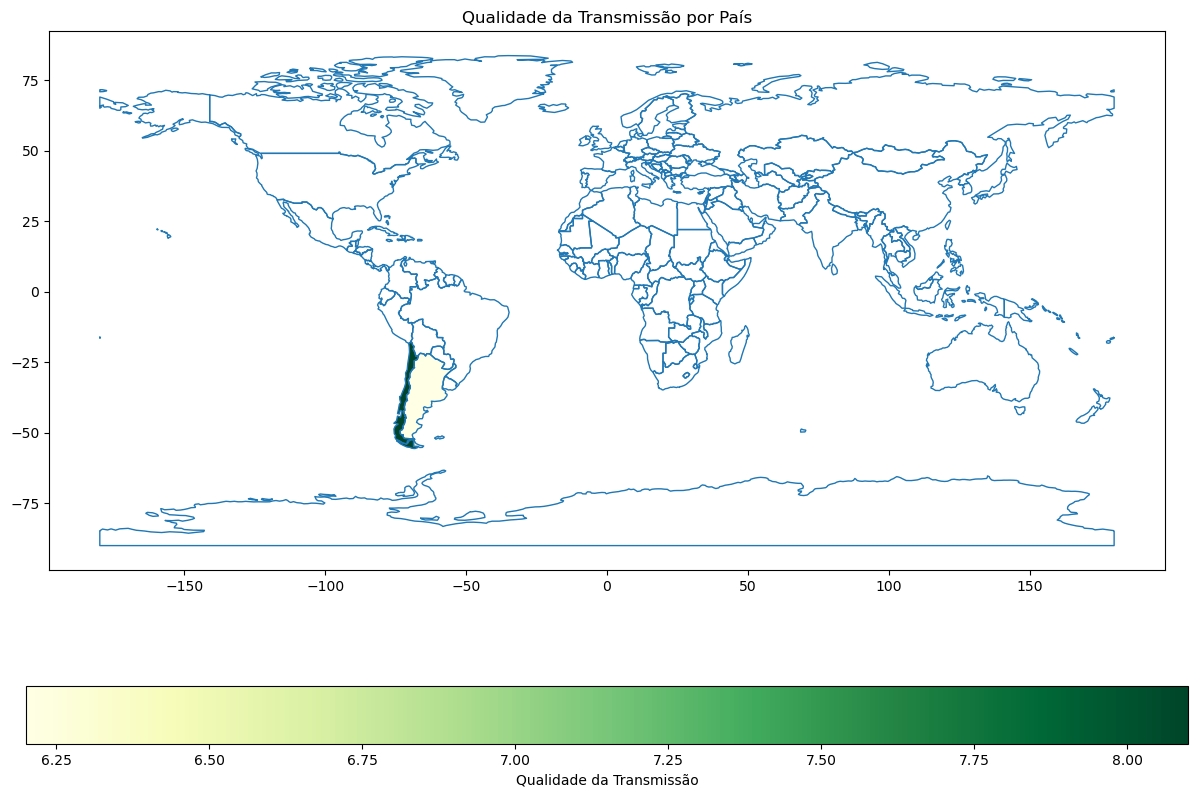

In [263]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Exemplo de dados de qualidade de transmissão por país
data = {
    'pais': ['brazil', 'Argentina', 'Chile', 'EUA', 'Alemanha', 'França'],
    'qualidade_transmissao': [7.5, 6.2, 8.1, 9.0, 8.5, 7.8]
}
df = pd.DataFrame(data)

# Carregar o shapefile do Natural Earth
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Merge entre os dados de qualidade e os dados geográficos
world = world.merge(df, left_on='NAME', right_on='pais', how='left')

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='qualidade_transmissao', ax=ax, legend=True,
           legend_kwds={'label': "Qualidade da Transmissão",
                        'orientation': "horizontal"},
           cmap='YlGn')

plt.title('Qualidade da Transmissão por País')
plt.show()


In [213]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Exemplo de array de nomes
nomes = np.array(['Alice', 'Bob', 'Charlie', 'Alice', 'Bob'])

# Inicializar o LabelEncoder
le = LabelEncoder()

# Transformar os nomes em valores escalares
valores_escalados = le.fit_transform(nomes)

print("Nomes originais:", nomes)
print("Valores escalados:", valores_escalados)

Nomes originais: ['Alice' 'Bob' 'Charlie' 'Alice' 'Bob']
Valores escalados: [0 1 2 0 1]


In [214]:
df = spark.read.format("org.apache.spark.sql.cassandra").options(table="qualidade_por_pais",keyspace="analises").load()

In [215]:
df.show()

+--------------------+--------------------+---------+
|                pais|              userid|qualidade|
+--------------------+--------------------+---------+
|british virgin is...|002e4fc7-5e5b-4a9...|       4K|
|british virgin is...|16bde4fb-d076-463...|       4K|
|british virgin is...|242b3a24-09b2-4de...|       4K|
|british virgin is...|295d571d-3432-446...|       4K|
|british virgin is...|31f347da-d4f7-499...|       4K|
|british virgin is...|32f23354-d0e7-425...|       HD|
|british virgin is...|34437f72-ddc5-419...|       4K|
|british virgin is...|3d149ccb-8cbe-484...|       SD|
|british virgin is...|3fa43e4c-4a2c-4c6...|       4K|
|british virgin is...|42efedd1-1815-4cc...|       SD|
|british virgin is...|48d722e7-0ecc-494...|       HD|
|british virgin is...|4916f9f7-49f6-4a2...|       HD|
|british virgin is...|53ab9069-068a-490...|       SD|
|british virgin is...|62ea216e-dc8d-484...|       SD|
|british virgin is...|6ee4a140-4a7d-4b0...|       SD|
|british virgin is...|72c538

In [217]:
df_qualidade = df.groupby(['pais', 'qualidade']).count()

In [219]:
df_qualidade.show()

+--------------------+---------+-----+
|                pais|qualidade|count|
+--------------------+---------+-----+
|           singapore|       HD|    9|
|              malawi|       HD|    6|
|          luxembourg|       SD|    8|
|           singapore|       4K|   10|
|              malawi|       SD|    7|
|        burkina faso|       HD|    5|
|              bhutan|       4K|   10|
|        burkina faso|       SD|   11|
|central african r...|       SD|    6|
|              bhutan|       SD|    5|
|        burkina faso|       4K|    6|
|             armenia|       4K|    8|
|          luxembourg|       HD|    9|
|      american samoa|       SD|   10|
|      american samoa|       HD|   11|
|             armenia|       HD|    9|
|              bhutan|       HD|    8|
|              malawi|       4K|    9|
|central african r...|       4K|    8|
|      american samoa|       4K|    8|
+--------------------+---------+-----+
only showing top 20 rows



In [222]:
df_qualidade.select("qualidade").distinct().show()

+---------+
|qualidade|
+---------+
|       4K|
|       SD|
|       HD|
+---------+



In [223]:
columns = ['4K', 'SD', 'HD']
colunas  = pd.DataFrame(columns=columns)

In [224]:
distinct_names = pd.concat([distinct_names, colunas], ignore_index=True)


In [225]:
distinct_names

,pais,Documentary,Sci-Fi,Comedy,Action,Drama,Thriller,idh,4K,SD,HD
0,austria,4,4,5,4,5,5,0.901,NaN,NaN,NaN
1,montserrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tunisia,2,3,1,3,5,6,0.75,NaN,NaN,NaN
3,saint helena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,haiti,2,4,3,1,2,6,0.503,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
238,burkina faso,3,1,2,5,4,7,0.484,NaN,NaN,NaN
239,malawi,2,7,4,2,5,2,0.5,NaN,NaN,NaN
240,singapore,2,4,5,8,8,4,0.935,NaN,NaN,NaN
241,armenia,4,8,4,4,6,6,0.776,NaN,NaN,NaN


In [232]:
rows = df_qualidade.collect()


In [234]:
for row in rows:
    distinct_names.loc[distinct_names.pais == row['pais'],row['qualidade']]= row['count']


In [235]:
distinct_names

,pais,Documentary,Sci-Fi,Comedy,Action,Drama,Thriller,idh,4K,SD,HD
0,austria,4,4,5,4,5,5,0.901,9,10,8
1,montserrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,13,6
2,tunisia,2,3,1,3,5,6,0.75,7,9,4
3,saint helena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,7,8
4,haiti,2,4,3,1,2,6,0.503,5,8,5
...,...,...,...,...,...,...,...,...,...,...,...
238,burkina faso,3,1,2,5,4,7,0.484,6,11,5
239,malawi,2,7,4,2,5,2,0.5,9,7,6
240,singapore,2,4,5,8,8,4,0.935,10,12,9
241,armenia,4,8,4,4,6,6,0.776,8,15,9


In [236]:
distinct_names_cleaned = distinct_names.dropna()


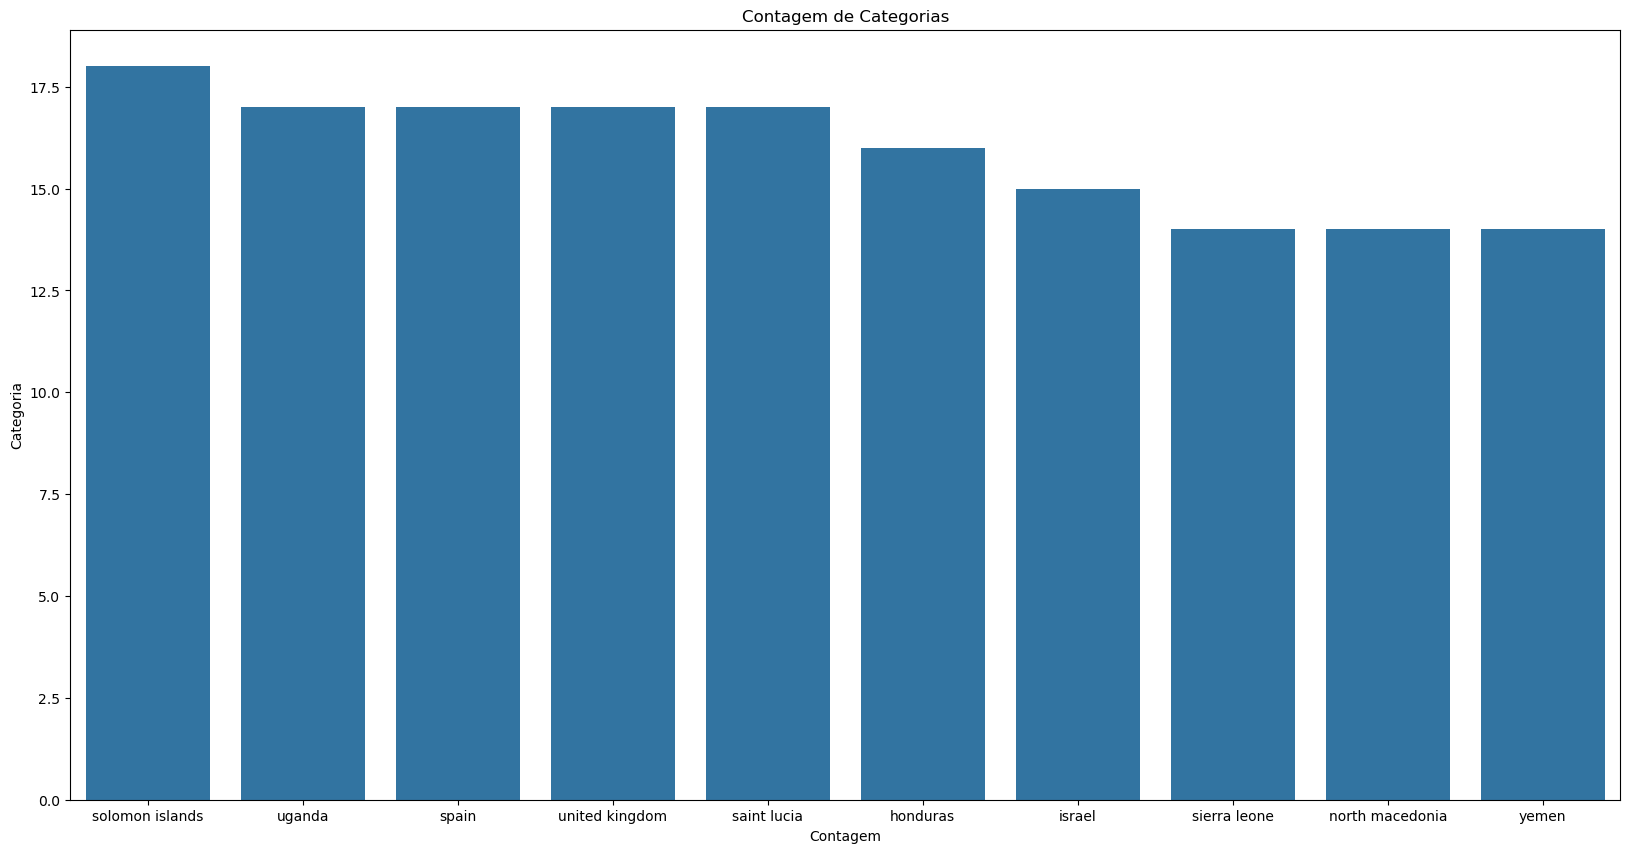

In [244]:
plt.figure(figsize=(20, 10))
#sns.countplot(y='4K', data=distinct_names_cleaned.sort_values(by='4K', ascending=False))
sns.barplot(x='pais', y='4K', data=distinct_names_cleaned.sort_values(by='4K', ascending=False).head(10))

# Adicionar título e rótulos
plt.title('Contagem de Categorias')
plt.xlabel('Contagem')
plt.ylabel('Categoria')

# Mostrar o gráfico
plt.show()

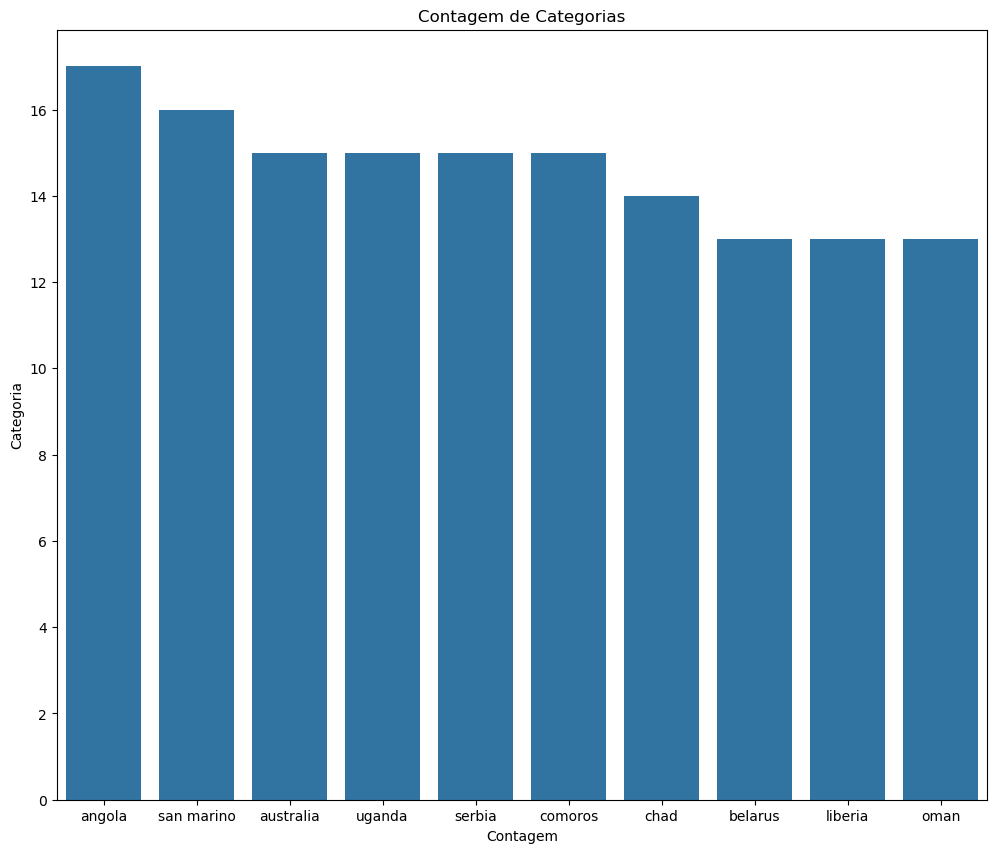

In [246]:
plt.figure(figsize=(12, 10))
#sns.countplot(y='4K', data=distinct_names_cleaned.sort_values(by='4K', ascending=False))
sns.barplot(x='pais', y='HD', data=distinct_names_cleaned.sort_values(by='HD', ascending=False).head(10))

# Adicionar título e rótulos
plt.title('Contagem de Categorias')
plt.xlabel('Contagem')
plt.ylabel('Categoria')

# Mostrar o gráfico
plt.show()

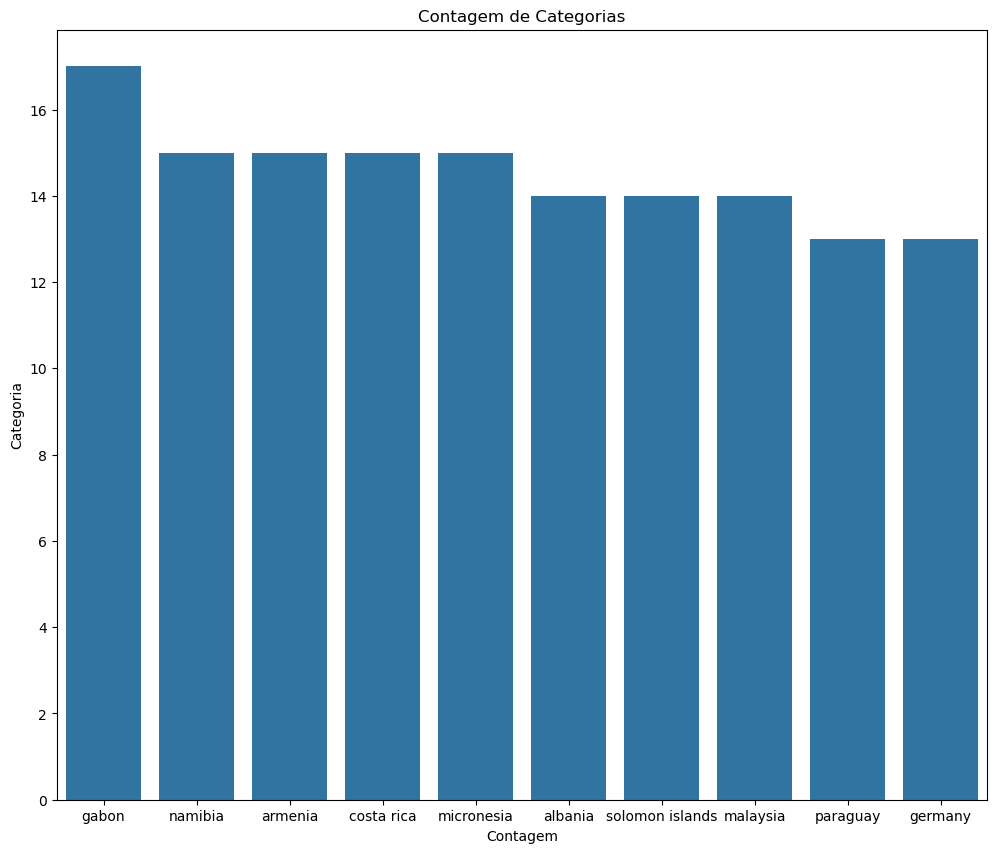

In [247]:
plt.figure(figsize=(12, 10))
#sns.countplot(y='4K', data=distinct_names_cleaned.sort_values(by='4K', ascending=False))
sns.barplot(x='pais', y='SD', data=distinct_names_cleaned.sort_values(by='SD', ascending=False).head(10))

# Adicionar título e rótulos
plt.title('Contagem de Categorias')
plt.xlabel('Contagem')
plt.ylabel('Categoria')

# Mostrar o gráfico
plt.show()

In [252]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)  # Queremos apenas um índice
#indice_pca = pca.fit_transform(data=distinct_names_cleaned,  )
df_pca = pd.DataFrame(data=distinct_names_cleaned, columns=['4K','HD','SD'])


In [256]:
indice_pca = pca.fit_transform(df_pca)

In [258]:
distinct_names_cleaned['Ranking'] = indice_pca

In [260]:
distinct_names_cleaned.sort_values(by='Ranking', ascending=False).head(10)

,pais,Documentary,Sci-Fi,Comedy,Action,Drama,Thriller,idh,4K,SD,HD,Ranking
23,uganda,12,5,6,7,4,5,0.512,17,7,15,9.973830
53,united kingdom,4,7,1,5,5,5,0.932,17,2,8,8.025807
147,angola,6,3,7,4,2,8,0.581,9,4,17,7.852406
177,madagascar,6,4,8,4,3,3,0.544,12,3,13,7.647411
198,saint lucia,7,7,6,8,4,3,0.758,17,7,11,7.463011
146,honduras,4,6,6,3,7,5,0.634,16,5,10,7.208123
119,serbia,7,6,7,6,1,2,0.825,10,4,15,7.202544
164,liberia,7,8,2,5,3,4,0.478,11,5,13,6.063500
69,oman,8,3,8,8,4,3,0.886,13,8,13,5.807049
64,south africa,5,5,3,3,5,4,0.709,13,3,9,5.742140


In [270]:
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')


In [271]:
world['SOVEREIGNT'] = world['SOVEREIGNT'].str.lower()


In [272]:
world

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,united republic of tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,western sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,united states of america,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Admin-0 country,1,5,republic of serbia,SRB,0,2,Sovereign country,1,Republic of Serbia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Admin-0 country,1,6,montenegro,MNE,0,2,Sovereign country,1,Montenegro,...,None,None,None,None,None,None,None,None,None,"POLYGON ((20.0707 42.58863, 19.80161 42.50009,..."
174,Admin-0 country,1,6,kosovo,KOS,0,2,Disputed,1,Kosovo,...,Admin-0 country,Unrecognized,Admin-0 country,Unrecognized,Admin-0 country,Admin-0 country,Admin-0 country,Admin-0 country,Unrecognized,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Admin-0 country,1,5,trinidad and tobago,TTO,0,2,Sovereign country,1,Trinidad and Tobago,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."


In [273]:
world = world.merge(distinct_names_cleaned, left_on='SOVEREIGNT', right_on='pais', how='left')


In [274]:
world

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,Sci-Fi,Comedy,Action,Drama,Thriller,idh,4K,SD,HD,Ranking
0,Admin-0 country,1,6,fiji,FJI,0,2,Sovereign country,1,Fiji,...,3,7,5,2,9,0.742,13,10,8,1.690161
1,Admin-0 country,1,3,united republic of tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Admin-0 country,1,7,western sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Admin-0 country,1,2,canada,CAN,0,2,Sovereign country,1,Canada,...,3,4,2,2,5,0.929,8,9,5,-2.731508
4,Admin-0 country,1,2,united states of america,US1,1,2,Country,1,United States of America,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Admin-0 country,1,5,republic of serbia,SRB,0,2,Sovereign country,1,Republic of Serbia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,Admin-0 country,1,6,montenegro,MNE,0,2,Sovereign country,1,Montenegro,...,4,5,3,4,5,0.811,5,11,10,-2.387991
174,Admin-0 country,1,6,kosovo,KOS,0,2,Disputed,1,Kosovo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,Admin-0 country,1,5,trinidad and tobago,TTO,0,2,Sovereign country,1,Trinidad and Tobago,...,9,2,5,2,5,0.792,8,11,10,-0.571349


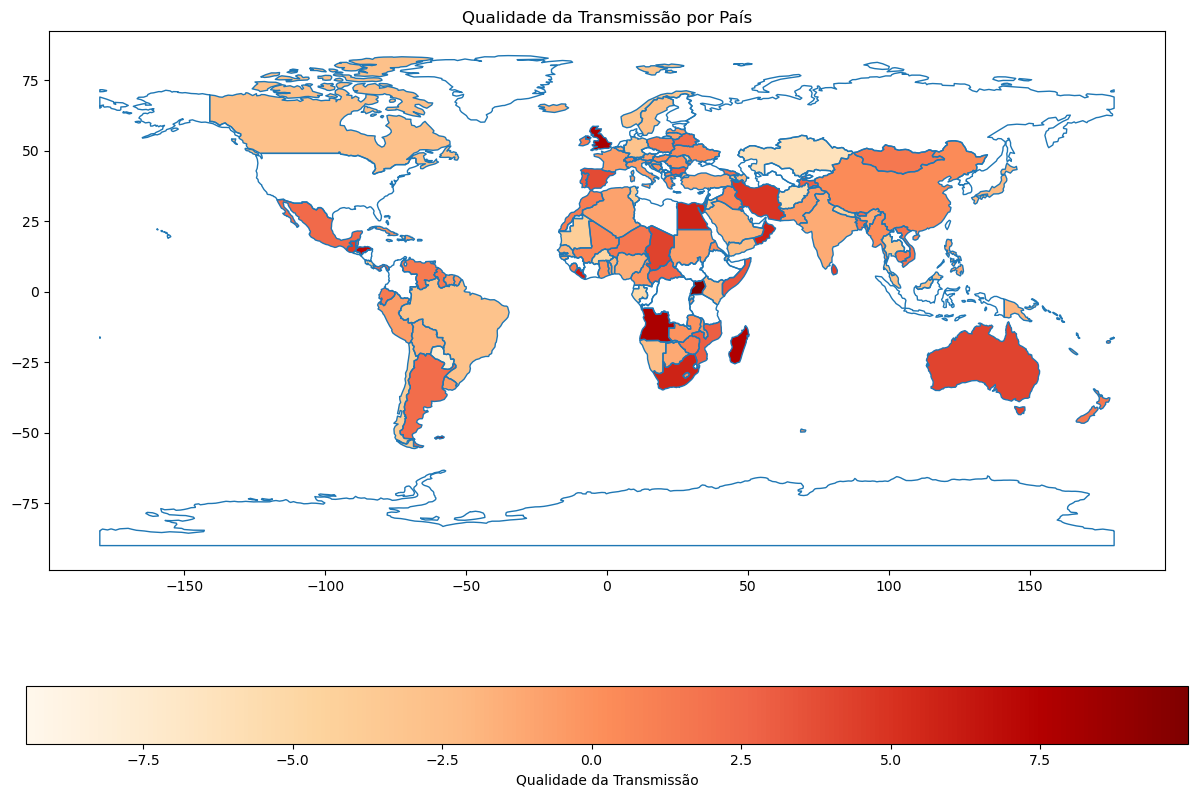

In [277]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='Ranking', ax=ax, legend=True,
           legend_kwds={'label': "Qualidade da Transmissão",
                        'orientation': "horizontal"},
           cmap='OrRd')

plt.title('Qualidade da Transmissão por País')
plt.show()